In [21]:
# pip install -r requirements.txt

In [22]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Data Understanding


## Test Read


In [24]:
test_image = "ALLIDB/Kelas 1/Asli-1.jpg"

img_bgr = cv2.imread(test_image)

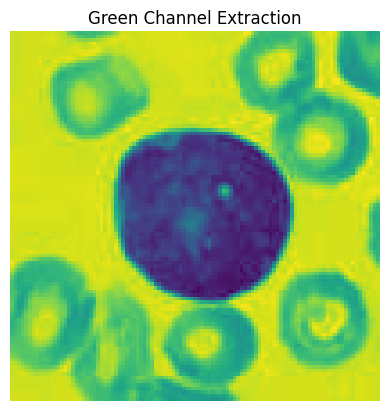

In [25]:
green_channel = img_bgr[:, :, 1]

plt.imshow(green_channel)
plt.title("Green Channel Extraction")
plt.axis('off')
plt.show()

## Read all data


In [26]:
def load_images(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            green_channel = img[:, :, 1]
            green_channel = cv2.resize(green_channel, target_size)
            images.append(green_channel)
            labels.append(label)
    return images, labels


kelas1_path = "ALLIDB/kelas 1"
kelas2_path = "ALLIDB/kelas 2"

kelas1_images, kelas1_labels = load_images(kelas1_path, 1) 
kelas2_images, kelas2_labels = load_images(kelas2_path, 2) 

images = kelas1_images + kelas2_images
labels = np.array(kelas1_labels + kelas2_labels)

In [27]:
len(images), len(labels)  

(260, 260)

In [28]:
images[0].shape

(128, 128)

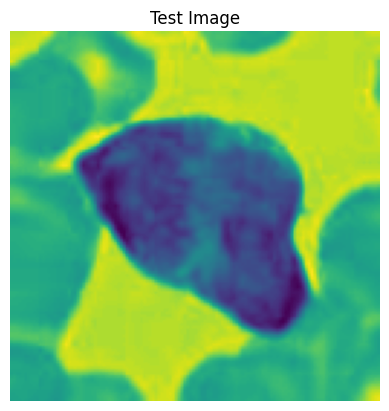

In [29]:
plt.imshow(images[3])
plt.title("Test Image")
plt.axis('off')
plt.show()

# Prepocessing


- https://blog.bigbox.co.id/image-segmentation-segmentasi-gambar-definisi-jenis-kelebihan-dan-penerapannya/
- https://www.baeldung.com/cs/otsu-segmentation


In [30]:
def otsu_threshold(image):
    hist = np.zeros(256)
    h, w = image.shape
    for i in range(h):
        for j in range(w):
            hist[image[i, j]] += 1
            
    hist /= (h * w) 
    
    best_thresh = 0
    max_var = 0
    for t in range(256):
        w0 = np.sum(hist[:t])
        w1 = np.sum(hist[t:])
        if w0 == 0 or w1 == 0:
            continue
        mu0 = np.sum(np.arange(t) * hist[:t]) / w0
        mu1 = np.sum(np.arange(t, 256) * hist[t:]) / w1
        var = w0 * w1 * (mu0 - mu1) ** 2
        if var > max_var:
            max_var = var
            best_thresh = t
    return best_thresh

def segment_otsu(image):
    thresh = otsu_threshold(image)
    segmented = np.where(image > thresh, 255, 0).astype(np.uint8)
    return segmented

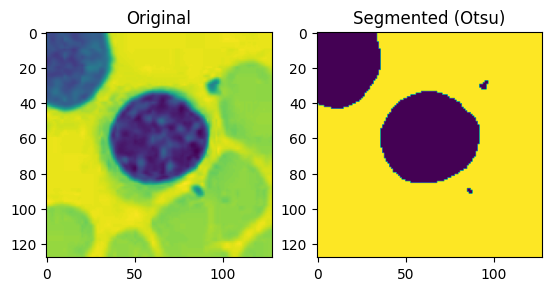

In [31]:


sample_image = images[21]
segmented = segment_otsu(sample_image)

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title("Segmented (Otsu)")
plt.show()

In [32]:
def compute_glcm(image, distance, angle):
    glcm = np.zeros((256, 256), dtype=np.uint32)
    h, w = image.shape
    angle_rad = angle * np.pi / 180 
    
    dx = round(distance * np.cos(angle_rad))
    dy = round(distance * np.sin(angle_rad))
    
    for i in range(h):
        for j in range(w):
            x = i + dx
            y = j + dy
            if 0 <= x < h and 0 <= y < w:
                glcm[image[i, j], image[x, y]] += 1
    

    glcm = glcm / np.sum(glcm)
    return glcm

![alt text](img/image.png)
![alt text](img/image-1.png)
![alt text](img/image-2.png)
![alt text](img/image-3.png)


In [33]:
def extract_features(glcm):
    contrast = 0
    energy = 0
    homogeneity = 0
    entropy = 0
    
    for i in range(glcm.shape[0]):
        for j in range(glcm.shape[1]):
            contrast += glcm[i, j] * (i - j) ** 2
            energy += glcm[i, j] ** 2
            homogeneity += glcm[i, j] / (1 + abs(i - j))
            if glcm[i, j] > 0:
                entropy -= glcm[i, j] * math.log(glcm[i, j])
    
    return [contrast, energy, homogeneity, entropy]

In [34]:
features = []
for img in images:
    segmented = segment_otsu(img)  
    glcm = compute_glcm(segmented, distance=1, angle=45)  
    features.append(extract_features(glcm))

features = np.array(features)

In [43]:
glcm

array([[0.42160084, 0.        , 0.        , ..., 0.        , 0.        ,
        0.02529605],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01953004, 0.        , 0.        , ..., 0.        , 0.        ,
        0.53357307]])

In [35]:
features 

array([[6.93427987e+02, 6.98815860e-01, 9.89377635e-01, 5.22067691e-01],
       [1.16512028e+03, 7.23413722e-01, 9.82151956e-01, 5.11406324e-01],
       [1.27800391e+03, 5.72986752e-01, 9.80422734e-01, 6.92285969e-01],
       ...,
       [3.10429971e+03, 4.68231183e-01, 9.52446389e-01, 8.70489488e-01],
       [7.74059148e+02, 7.32920964e-01, 9.88142476e-01, 4.83609979e-01],
       [2.91481648e+03, 4.63468802e-01, 9.55349012e-01, 8.69186586e-01]])

# Modelling


In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [37]:
len(X_train), len(X_test), len(y_train), len(y_test)

(208, 52, 208, 52)

In [38]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def predict(X_train, y_train, X_test, k):
    y_pred = []
    for test_sample in X_test:
        distances = [euclidean_distance(train_sample, test_sample) for train_sample in X_train]
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        pred = np.argmax(np.bincount(nearest_labels))
        y_pred.append(pred)
    return np.array(y_pred)

y_pred = predict(X_train, y_train, X_test, k=3)

In [39]:
print("=== Euclidean Distance ===")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

=== Euclidean Distance ===
Confusion Matrix:
[[17  9]
 [ 9 17]]
Accuracy: 0.6538
Precision: 0.6538
Recall: 0.6538
F1-Score: 0.6538
